In [2]:
%pylab inline
import astropy.units as u
from LSSTFringe import utils,plot_utils,TMMSIM
index_of_refraction = utils.load_refraction_data(Epoxy_ind=1.6,Temp = 173.)
from numba import jit
from tqdm import tqdm
from astropy.io import fits
import os

plot_utils.init_plot_style()

Populating the interactive namespace from numpy and matplotlib


Paper Figure 7

In [33]:
@jit(nopython = True,nogil=True)
def E2V_model(d_epoxy,n_list,angle,wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,d_epoxy,165, np.inf])

    # Assume normal incidence.
    theta = angle
    R = T = 0
    #for pol in 's':
    for pol in 'sp':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        R += 0.5*Res[2]
        T += 0.5*Res[3]

    A = 1 - R - T

    return(A)
@jit(nopython = True,nogil=True)
def line_sim(n_list,field,theta,wlen):
    Fringe_map = np.zeros_like(field)
    for j in range(len(field)):
        Fringe_map[j] = E2V_model(d_epoxy= field[j],n_list = n_list,angle = theta,wlen=wlen)
    
    return(Fringe_map)

In [27]:
RTM_020_Seq = ['E2V-359','E2V-321','E2V-319','E2V-363',
               'E2V-357','E2V-364','E2V-361','E2V-365','E2V-350']
Name = ['S20','S21','S22','S10','S11','S12','S00','S01','S02']
RTM_020_Seq.reverse()

def fringe_sim (unqiue_idx,return_idx,wavelength):
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    n_list = np.array([index_of_refraction[m](960) for m in material])
    A = line_sim(n_list,unqiue_idx,0,wlen=wavelength)
    final = A[return_idx]
    final = final.reshape(3974,4000)
    return(final)

sim_results = []
for i in range(len(RTM_020_Seq)):
    hh = fits.open('data/sensor/%s.fits'%RTM_020_Seq[i])
    MAP = hh[1].data['sim']
    MAP = np.array(MAP,dtype = float)
    unqiue_idx, return_idx = np.unique(MAP,return_inverse=True)
    sim_results.append(fringe_sim(unqiue_idx=unqiue_idx,return_idx=return_idx,wavelength=960))
    
plt.figure(figsize = (15,15))
for i in range(len(RTM_020_Seq)):
    plt.subplot(3,3,i+1)
    plt.title(Name[i]+ ': '+RTM_020_Seq[i])
    plt.imshow(sim_results[i],origin='upper',cmap = pylab.cm.hot)
    plt.gca().invert_xaxis()
    plt.axis('off')
    #plt.savefig('Paper_plots/RTM-020-Sim.eps')

Paper Figure 5

100%|███████████████████████████████████████████| 81/81 [00:17<00:00,  4.67it/s]


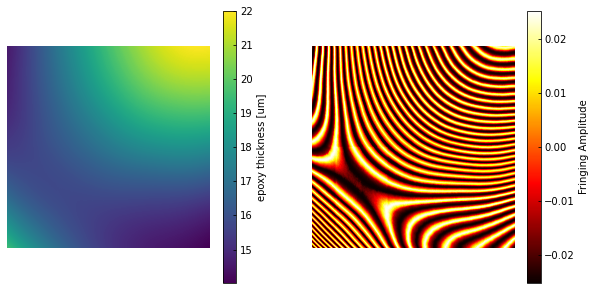

In [37]:
hh = fits.open('data/sensor/E2V-321.fits')
MAP = hh[1].data['sim']

MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)
unqiue_idx, return_idx = np.unique(MAP,return_inverse=True)
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma
    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)

avg_wlen_width = 2
window =80

cen_wav = 960
x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)

# Assign weight to each point based on the gaussian
weight = gaussian(x,cen_wav,avg_wlen_width)


b = np.zeros_like(unqiue_idx)
for k in tqdm(range(len(x))):
    wlen = x[k]
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    n_list = np.array([index_of_refraction[m](wlen) for m in material])
    b += weight[k]*line_sim(n_list,unqiue_idx,0,wlen=x[k])#E2V_model(d_si2= height_f2[i,j]*scale_factor2,wlen=x[k])
b2 = b/np.sum(weight)

final = b2[return_idx]
final = final.reshape(3974,4000)

plt.figure(figsize = (10,5))
plt.subplot(122)
g = (final.max() + final.min())/2
plt.imshow(final-g,cmap = pylab.cm.hot,origin = 'lower')
plt.colorbar(label = 'Fringing Amplitude')
plt.axis('off')
plt.subplot(121)
#plt.savefig('data/Paper_plots/E2V-321-SIM.eps',)
plt.imshow(Fitting,origin = 'lower')
plt.axis('off')
plt.colorbar(label = 'epoxy thickness [um]')
#plt.savefig('data/Paper_plots/e2v-321-map_sim.eps')

Figure 6

Text(0, 0.5, 'Fringing amplitude')

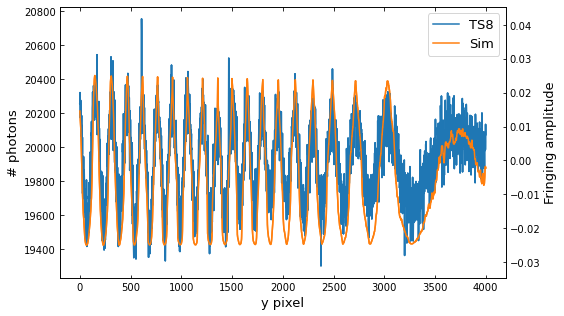

In [45]:
from scipy.ndimage import gaussian_filter
assem = fits.open('../AstroCCD-master/data/Nice-Sample/E2V-321/E2V-321-960.fits')
assembled = assem[0].data
assembled = assembled[15:-15,48:-48]
# Normalize the the fringe flats via dividing the overall mean of the flat field.

Fringe_amp = assembled/np.mean(assembled)-1
smoothed = gaussian_filter(assembled, sigma=0.6)
Slice = smoothed[3000,:]
g = (np.max(final[3000,:])+np.min(final[3000,:]))/2
#g = np.mean(final)
#noise =  random.normal(0,0.007,size = b.size)


#noise =  random.normal(0,0.00,size = (400,400))
tt =final[3000,:]-g

smoothed_data = Slice
num_photon_sim = (tt+1)*np.mean(Slice)
fringing_data = Slice/np.mean(Slice)-1
fringing_sim = tt

fig, ax1 = plt.subplots(figsize = (8,5))
ax2 = ax1.twinx()

ax1.plot(smoothed_data,label = 'TS8')
ax1.plot(num_photon_sim,label = 'Sim')


ax2.plot(fringing_data)


ax2.plot(fringing_sim)




ax1.legend(loc = 'best',fontsize= 13)
ax1.set_xlabel('y pixel',fontsize = 13)
ax1.set_ylabel('# photons',fontsize = 13)
ax2.set_ylabel('Fringing amplitude',fontsize= 13);
#plt.savefig('../../Paper_plots/E2V-321-detail-compare.eps')